<a href="https://colab.research.google.com/github/antahiap/dsr-nlp/blob/main/notebooks/04_language_generation_lsdyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm
import time

In [16]:
!rm -rf dataset

In [18]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/antahiap/dsr-nlp #https://github.com/vilmibm/lovecraftcorpus

    # Find all the files.
    paths_all = glob.glob("dsr-nlp/data/mat/*.txt")
    print(sorted(paths_all))

    # Do not use all.
    paths_all = paths_all[:]#:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf dsr-nlp

    # Done.
    print("Corpus downloaded.")

Cloning into 'dsr-nlp'...
remote: Enumerating objects: 960, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 960 (delta 86), reused 194 (delta 75), pack-reused 744
Receiving objects: 100% (960/960), 88.84 MiB | 15.38 MiB/s, done.
Resolving deltas: 100% (120/120), done.
['dsr-nlp/data/mat/MAT_00.txt', 'dsr-nlp/data/mat/MAT_001.txt', 'dsr-nlp/data/mat/MAT_001_FLUID.txt', 'dsr-nlp/data/mat/MAT_002.txt', 'dsr-nlp/data/mat/MAT_002_ANIS.txt', 'dsr-nlp/data/mat/MAT_002_ANISO.txt', 'dsr-nlp/data/mat/MAT_003.txt', 'dsr-nlp/data/mat/MAT_004.txt', 'dsr-nlp/data/mat/MAT_005.txt', 'dsr-nlp/data/mat/MAT_006.txt', 'dsr-nlp/data/mat/MAT_007.txt', 'dsr-nlp/data/mat/MAT_008.txt', 'dsr-nlp/data/mat/MAT_009.txt', 'dsr-nlp/data/mat/MAT_010.txt', 'dsr-nlp/data/mat/MAT_010_SPALL.txt', 'dsr-nlp/data/mat/MAT_010_ST.txt', 'dsr-nlp/data/mat/MAT_011.txt', 'dsr-nlp/data/mat/MAT_011_LUND.txt', 'dsr-nlp/data/mat/MAT_012.txt', 'dsr-nlp/data/mat/MAT

# Data Setup

In [19]:
def create_dataset(data_path):
  dataset = preprocessing.text_dataset_from_directory(
      data_path,
      labels=None,
      batch_size=32,  # not training
      seed=42
  )
  return dataset

In [20]:
dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 762 files belonging to 1 classes.
Found 609 files belonging to 1 classes.
Found 153 files belonging to 1 classes.


In [24]:
for batch in dataset_original_all:
  for sample in batch:
    print(sample)
    break

tf.Tensor(b': *.  \n*.   \n *.   *.   \n  VARIABLE   DESCRIPTION  \nG Shear modulus for frequency independent damping.  F requency \nindependent damping is based on a spring and slider  in series.  \nThe critical stress for the slider mechanism is SIG F de\xef\xac\x81ned below.  \nFor the best results, the value of G should be 250- 1000 times \ngreater than SIGF. \nSIGF Limit stress for frequency independent, fricti onal, damping. \nREF Use reference geometry to initialize the stress ten sor.  The \nreference geometry is de\xef\xac\x81ned by the keyword:*INITIA L_FOAM_-\nREFERENCE_GEOMETRY (see there for more details). \nEQ.0.0: o\xef\xac\x80, \nEQ.1.0: on. \nPRTEN The tensile Poisson\xe2\x80\x99s ratio for shells (optio na l).  If PRTEN is zero, \nPR/BETA will serve as the Poisson\xe2\x80\x99s ratio for both tension and \ncompression in shells.  If PRTEN is nonzero, PR/BET A will serve \nonly as the compressive Poisson\xe2\x80\x99s ratio for shells.    \nSGL Specimen gauge length \nSW

In [25]:
vocabulary_size = 10_000      # state of art: 50_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,  # REconsider, keep puctuations and cappitalize
    split='whitespace',
    output_mode='int'
)

encoder.adapt(dataset_original_all)

In [26]:
vocabulary = encoder.get_vocabulary()
print(vocabulary[:100])
print(vocabulary[100:])

['', '[UNK]', 'the', 'is', 'of', 'F', 'and', 'for', 'a', 'in', 'to', '*.', '=', 'as', 'strain', '1', 'The', 'be', 'Card', '2', 'are', 'stress', 'curve', '3', 'by', 'This', '4', 'with', 'material', '0', '5', '6', 'or', '.', '8', 'function', 'VARIABLE', 'DESCRIPTION', 'Type', '7', 'Variable', 'on', '0.0', 'ID', 'if', 'rate', 'that', 'Y', 'plastic', ',', 'element', 'value', 'shear', 'this', 'at', 'deﬁned', 'failure', 'If', 'yield', 'I', 'A', 'used', 'card', 'none', 'damage', 'Material', 'an', '(see', 'load', 'model', 'can', 'from', '+', '−', 'where', 'which', 'not', 'parameter', 'AOPT', 'Load', 'LS-DYNA', 'For', 'Remark', 'option', 'axes', 'given', 'modulus', 'R13', 'deﬁning', 'e', 'see', 'number', 'MID', 'only', 'See', 'may', 'values', 'hardening', 'must', 't']
['(MAT)', 'table', 'Default', 'RO', '1.', 's', 'when', 'set', 'input', 'eﬀective', 'temperature', 'ﬁber', '-', 'will', 'time', 'In', 'Figure', 'i', 'BETA', 'factor', '2.', 'using', 'it', 'tensile', 'required.', 'determined', 'loca

# Dataset for Autoregression

In [27]:
sequence_length = 32      # state of art: 4000
padding_token_id = 0

def create_dataset_for_autoregression(dataset):
  x_inputs = []
  y_outputs = []

  for books in dataset:
    # print(books.shape)  #(16, 1)
    books = encoder(books).numpy()
    # print(list(books[0][-100:]))   #  many zeros due to the padding

    for book in tqdm(books):

      # Remove the pddding from the end
      book = [x for x in list(book) if x!=padding_token_id]

      # Add üadding at the begining
      padding = [padding_token_id] * sequence_length
      book = padding + book

      # Create inputs and outputs
      for start_index in range(0, len(book)-sequence_length):
        x = book[start_index:start_index + sequence_length]
        assert len(x) == sequence_length
        y = book[start_index + sequence_length]

        x_inputs += [x]
        y_outputs += [y]


  return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))

dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)
print('Done!')

100%|██████████| 25/25 [00:00<00:00, 751.30it/s]


Done!


In [28]:
def decode(indices):
  return ''.join([vocabulary[index] for index in indices])

In [29]:
for input, output in dataset_train.take(4):
  print('input: ', ', '.join([str(x) for x in input.numpy()]))
  print('output:', output.numpy())

  print('input decoded: ', decode(input))
  print('output decoded: ', decode([output]))

input:  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
output: 212
input decoded:  
output decoded:  :
input:  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212
output: 11
input decoded:  :
output decoded:  *.
input:  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 11
output: 11
input decoded:  :*.
output decoded:  *.
input:  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212, 11, 11
output: 11
input decoded:  :*.*.
output decoded:  *.


In [30]:
def render_history(history):
  assert isinstance(history, dict), f"Expected dict, but got {type(history)}"

  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label="val_loss")
  plt.legend()
  plt.show()

  plt.plot(history['accuracy'], label="accuracy")
  plt.plot(history['val_accuracy'], label="val_accuracy")
  plt.legend()

# Train LSTM

In [ ]:
embedding_size = 128
model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))  # index to vec size of 128
model.add(layers.LSTM(256))
model.add(layers.Dense(vocabulary_size, activation='softmax'))


model.summary()


model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    dataset_train.cache().shuffle(1_000_000).batch(2**6),    # batch is big to make in run quicker
    epochs=10,
    validation_data = dataset_valid.cache().batch(2**6)
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 256)               394240    
                                                                 
 dense_2 (Dense)             (None, 10000)             2570000   
                                                                 
Total params: 4,244,240
Trainable params: 4,244,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
9795/9795 [==============================] - 119s 12ms/step - loss: 4.9780 - accuracy: 0.2671 - val_loss: 3.8878 - val_accuracy: 0.3751
Epoch 2/10
9335/9795 [===========================>..] - ETA: 3s - loss: 3.3602 - accuracy: 0.4144

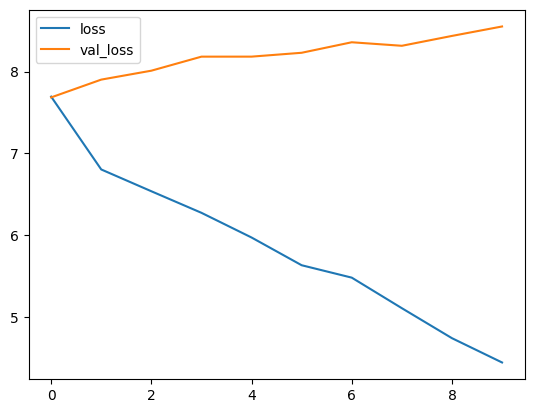

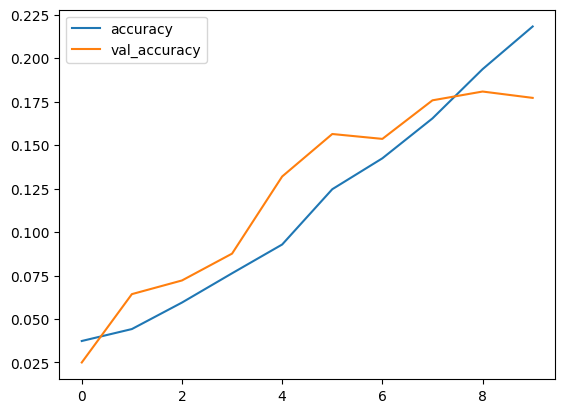

In [15]:
import matplotlib.pyplot as plt

model.save("model/model_02.h5")
render_history(history.history)

In [ ]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=0)
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """
    # temperture extend the range of the norm, from deufult to uniform distribution

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature

        # Softmax
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction) # Prob distribution

        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate(model, "we are all doomed", 100, temperature=1.0)